# Self-distillation with Kernel Ridge Regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
my_cmap = plt.get_cmap('viridis')
plt.rcParams.update({'figure.figsize': (7, 4)})
plt.rcParams.update({'figure.dpi': 150})
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'figure.autolayout': True})

We define a self-distillation class, which fit a kernel ridge regression model with RBF kernel for some specified amount of times with tha provided distillation parameter `alpha` and regularization parameter `lambd`. The MSE loss with the true (noiseless) underlying sine function is printed and the solutions plotted on a single plot. If the amount of distillation steps exceed 20, only some solutions are plotted.

In [3]:
class Recurser(object):
    """Calculate B recursively based on provided A and alpha, according to
    recursive formula in paper."""
    def __init__(self, A, alpha):
        self.A = A
        self.B = np.copy(A)
        self.alpha = alpha
        
    def _update_step(self):
        self.B = np.matmul(self.A, (1-self.alpha)*self.B + self.alpha*np.identity(self.B.shape[0]))
    
    def update(self, steps=1):
        for i in range(steps):
            self._update_step()
        
    def get(self, val='B'):
        return getattr(self, val.upper())

In [4]:
class SelfDistill(object):
    def __init__(self, X, Y, lambd=1e-6, rbf_gamma=8):
        self.X = X
        self.Y = Y
        self.lambd = lambd
        self.rbf_gamma = rbf_gamma
        
        self.K = metrics.pairwise.rbf_kernel(self.X, gamma=self.rbf_gamma)
        self.K_ridge = np.matmul(self.K, np.linalg.inv(self.K + self.lambd*np.identity(len(self.Y))))
        
        self.distilled_steps = 0
        self._Y_distill = [Y]
        self._Y_pred = []
        
    def distill(self, alpha=0.1, steps=1, x=np.arange(0, 1.01, 0.01), return_all=False):
        self.alpha = alpha
        x = x.reshape(-1, 1)

        # Plot
        plt.figure()
        #plt.plot(x, np.sin(x*2*np.pi), 'k', linewidth=1, label='True func.')
        plt.scatter(self.X, self.Y, marker='x', c='k', label=r'$\mathcal{D}_{\mathrm{train}}$')
        
        # Status print
        print('Step\tLoss')
        print('---'*5)
        
        # Perform distillation and plot/print
        for step in range(1, steps+1):
            # Calculate Y_t
            self._Y_distill.append(np.matmul(self.K_ridge, alpha*self.Y + (1-alpha)*self._Y_distill[step-1]))
            
            # Calculate/predict with f_t on x
            K_func_ridge = np.matmul(self.kernel(x), np.linalg.inv(self.K + self.lambd*np.identity(len(Y))))
            Y_pred = np.matmul(K_func_ridge, alpha*self.Y + (1-alpha)*self._Y_distill[step-1])
            self._Y_pred.append(Y_pred)

            if steps < 11:
                plt.plot(x, Y_pred, label=f'$f_{{{step}}}$', color=my_cmap((step-1)/steps))
            else:
                if step % (steps // 10) == 0:
                    plt.plot(x, Y_pred, label=f'$f_{{{step}}}$', color=my_cmap((step-1) / (steps // 10)))
            
            # Print status
            print(f'{step}\t{self.loss(x, Y_pred):1.5f}')
            
        # Calculate limiting solution
        Y_lim = np.matmul(np.matmul(alpha*self.kernel(x), np.linalg.inv(alpha*self.K + self.lambd*np.identity(len(self.Y)))), self.Y)
        plt.plot(x, Y_lim, 'k--', label='$f_{\infty}$')
        self.Y_lim = Y_lim
        
        # Finalize plot
        plt.ylim(-1.5, 1.5)
        plt.legend(loc='lower left', ncol=steps+2 if steps < 11 else 10+2, mode='expand')
        
        print('---'*5)
        print(f'∞\t{self.loss(x, Y_lim):1.5f}')
        self.distilled_steps = steps
        if return_all:
            return self._Y_pred
        
    def kernel(self, x):
        return metrics.pairwise.rbf_kernel(x, self.X, gamma=self.rbf_gamma)

    def loss(self, x, Y_t):
        return np.mean(np.square(Y_t - np.sin(x*2*np.pi)))
    
    def get_B(self, return_all=False):
        self.V, self.D, self.VT = np.linalg.svd(self.K, hermitian=True)
        self.D = np.diag(self.D)
        self.A = np.matmul(self.D, np.linalg.inv(self.D + self.lambd*np.identity(self.D.shape[0])))
        self.B_recurser = Recurser(self.A, self.alpha)
        
        # Calculate recursive B
        if return_all:
            Bs = []
            Bs.append(np.copy(self.B_recurser.get('B')))
            for i in range(1,self.distilled_steps):
                self.B_recurser.update(steps=1)
                Bs.append(np.copy(self.B_recurser.get('B')))
            
            # Get limiting B:
            self.B_lim = np.matmul(self.alpha*self.D, np.linalg.inv(self.alpha*self.D + self.lambd*np.identity(self.D.shape[0])))
            return(Bs, self.B_lim)
        else:
            self.B_recurser.update(steps=self.distilled_steps)
            return(np.copy(self.B_recurser.get('B')))
            

First we generate some data. Here, we use the exact same values as in Mobahi, Farajtabar, Bartlett (2020).

In [5]:
np.random.seed(7)
X = np.arange(0, 1.1, 0.1).reshape(-1, 1)
Y = np.array([0.38476636465198066, 1.2333967683416893, 1.33232242218057, 0.69201594888895180, -0.29756145531871736, -0.24189291901377769, -0.7964485769175675, -0.9616480167034174, -0.49672509509916934, -0.3469066003991437, 0.5589512650600734])
#Y = np.sin(X*2*np.pi) + np.random.normal(0, 0.5, size=len(X)).reshape(-1, 1)
Y = Y.reshape(-1, 1)

We can plot the simulated data along with the true underlying function we have simulated from.

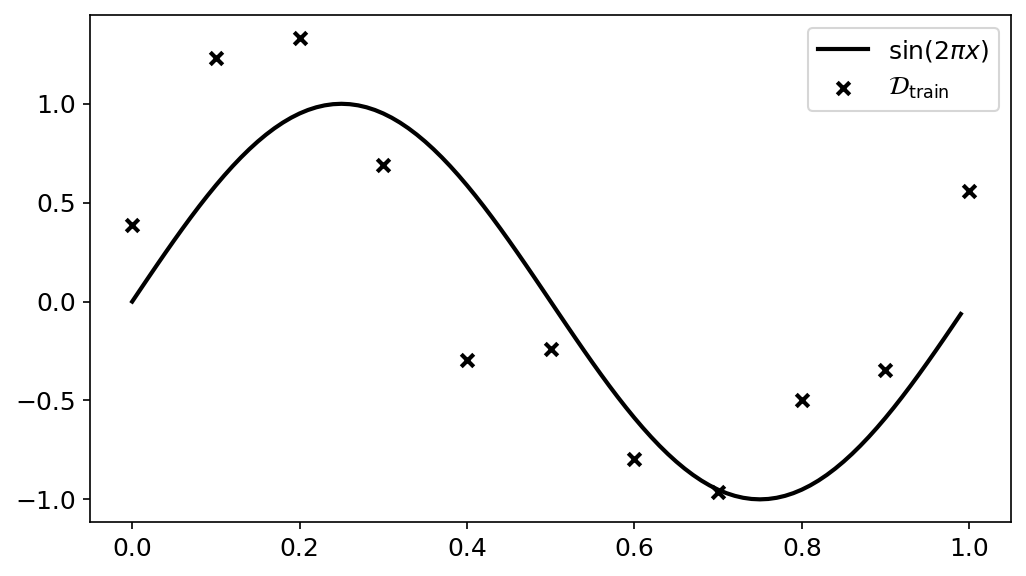

In [6]:
x = np.arange(0, 1, 0.01)
plt.plot(x, np.sin(x*2*np.pi), c='k', label=r'$\sin(2\pi x)$', linewidth=2)
plt.scatter(X, Y, marker='x', c='k', label=r'$\mathcal{D}_{\mathrm{train}}$')
plt.legend();

In the following we perform self-distillation without the use of ground truth data (except in the first step). We see how the solution quickly converges towards the zero function.

Step	Loss
---------------
1	0.16477
2	0.15076
3	0.14915
4	0.15561
5	0.16735
6	0.18251
---------------
∞	0.49505


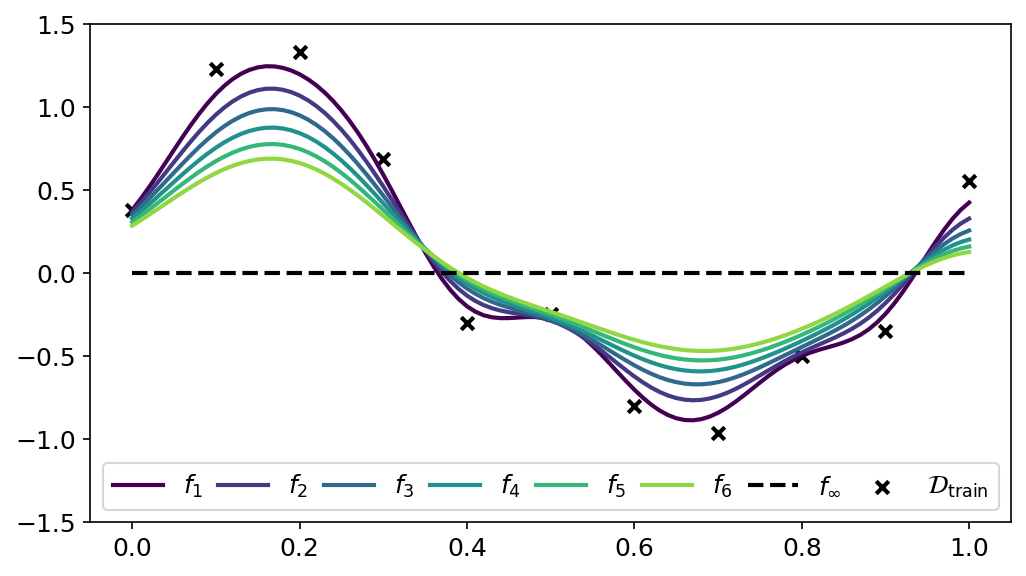

In [7]:
gamma = 80
lambd = 2e-1
steps = 6
distiller_no_GT = SelfDistill(X, Y, lambd=lambd, rbf_gamma=gamma)
distiller_no_GT.distill(alpha=0.0, steps=steps)

Step	Loss
---------------
1	0.16477
2	0.15309
3	0.14958
4	0.14903
5	0.14946
6	0.15011
---------------
∞	0.15250


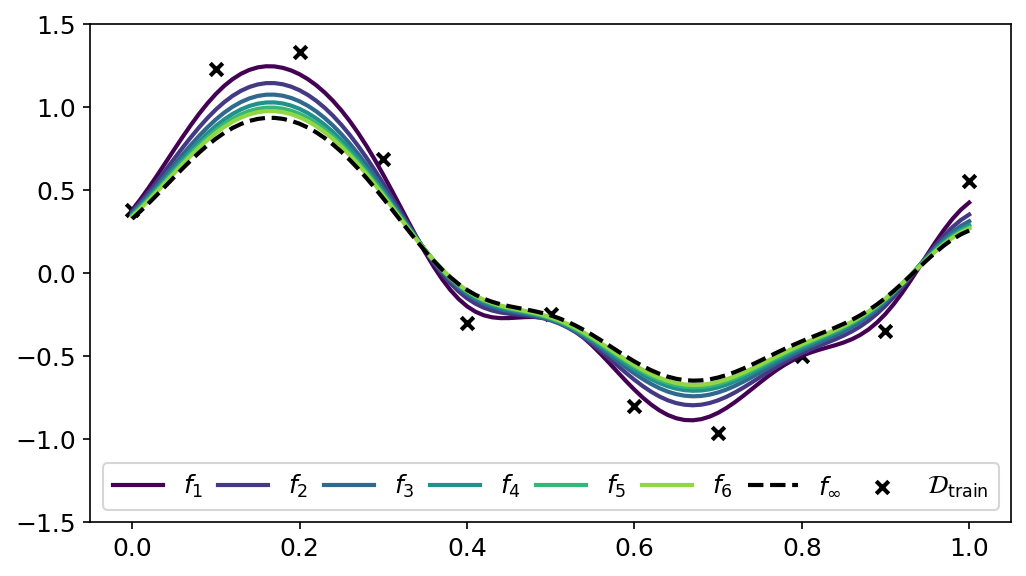

In [8]:
distiller_GT = SelfDistill(X, Y, lambd=lambd, rbf_gamma=gamma)
distiller_GT.distill(alpha=0.25, steps=steps)

Now, if we calculate the $B^{(\tau)}$ (can be done recursively), and plot the diagonal, we get the following.

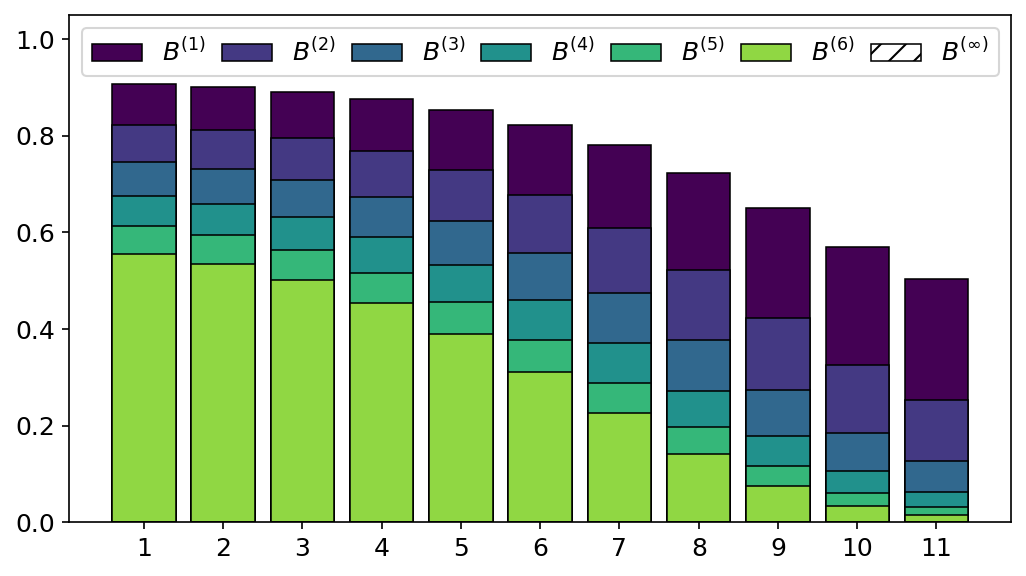

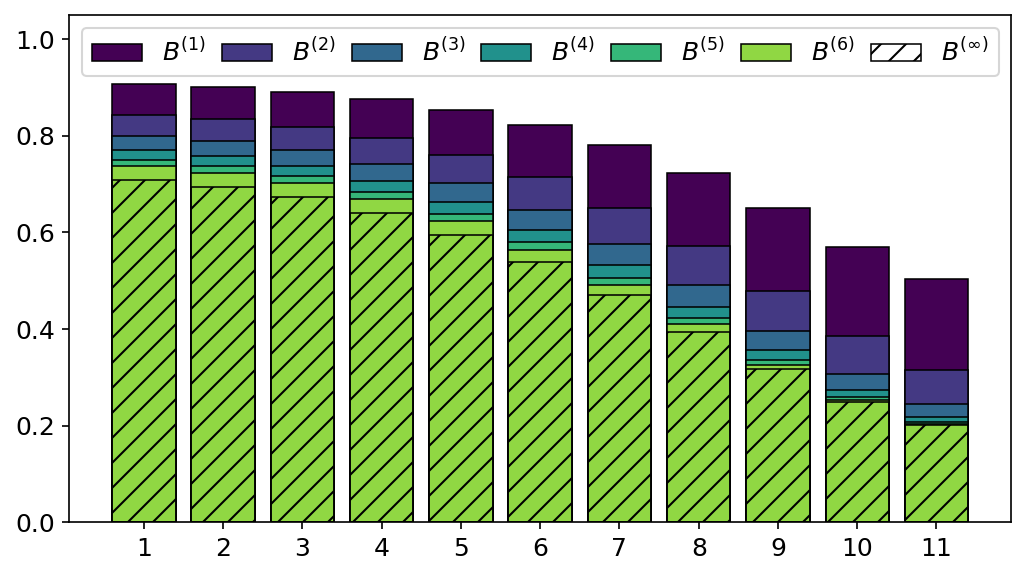

In [9]:
plt.figure()
Bs_no_GT, Bs_no_GT_lim  = distiller_no_GT.get_B(return_all=True)
for B, i in zip(Bs_no_GT, range(len(Bs_no_GT))):
    plt.bar(range(1, len(B)+1), np.diag(B), label=fr'$B^{{({i+1})}}$', color=my_cmap(i/len(Bs_no_GT)), edgecolor='black', linewidth=0.75)
    plt.ylim(0,1.05) 
plt.bar(range(1, len(Bs_no_GT_lim)+1), np.diag(Bs_no_GT_lim), label=r'$B^{(\infty)}$', fill=False, edgecolor='black', hatch="//", linewidth=0.75)    
plt.legend(loc='upper left', ncol=len(Bs_no_GT[0]), mode='expand')
plt.xticks(range(1, len(B)+1))
plt.savefig('figures/B_no_GT.pdf')
plt.show();

plt.figure()
Bs_GT, Bs_GT_lim = distiller_GT.get_B(return_all=True)
for B, i in zip(Bs_GT, range(len(Bs_GT))):
    plt.bar(range(1, len(B)+1), np.diag(B), label=fr'$B^{{({i+1})}}$', color=my_cmap(i/len(Bs_GT)), edgecolor='black', linewidth=0.75)
    plt.ylim(0,1.05)
plt.bar(range(1, len(Bs_GT_lim)+1), np.diag(Bs_GT_lim), label=r'$B^{(\infty)}$', fill=False, edgecolor='black', hatch="//", linewidth=0.75)    
plt.legend(loc='upper left', ncol=len(Bs_no_GT[0]), mode='expand')
plt.xticks(range(1, len(B)+1))
plt.savefig('figures/B_GT.pdf')
plt.show();

In the following we plot the ratio between each consecutive diagonal, i.e. $B_1/B_2$, $B_2/B_3$, etc. for each distillation step. We quickly observe that for $\alpha = 0$ the ratios are increasing in $\tau$, but for $\alpha = 0.35$, they are increasing for a few epochs, and then does not change any more.

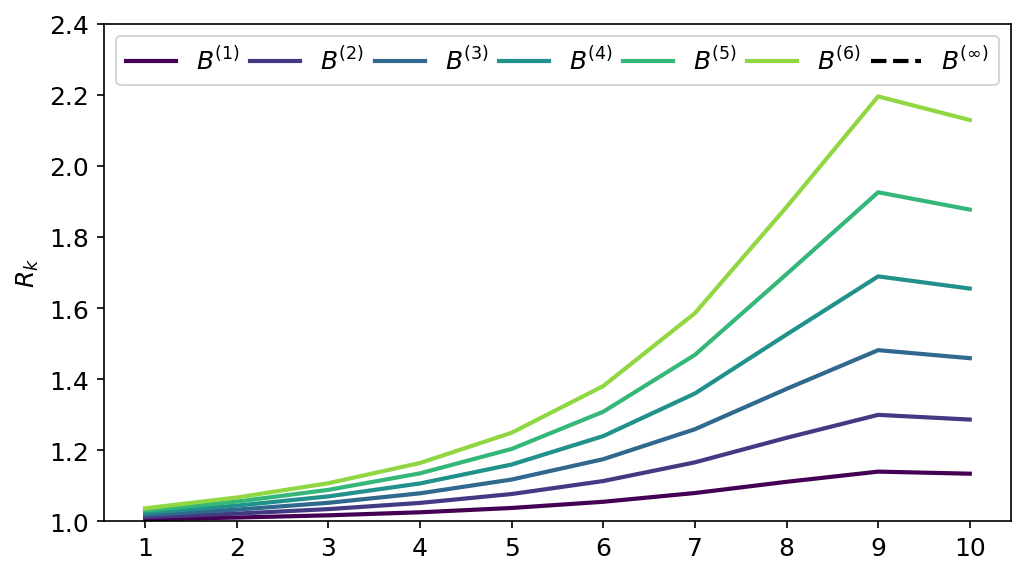

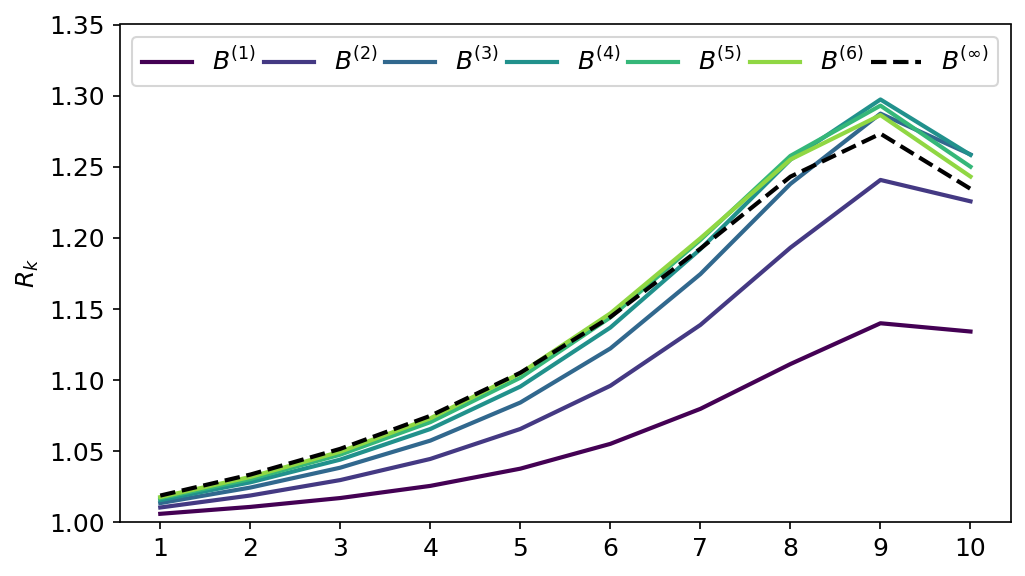

In [11]:
Bs = [np.diag(B) for B in Bs_no_GT]
Bs = np.stack([B[:-1]/B[1:] for B in Bs], axis=1).transpose()

plt.figure()
for B, i in zip(Bs, range(len(Bs))):
    plt.plot(range(1, len(B)+1), B, color=my_cmap(i/len(Bs)), label=fr'$B^{{({i+1})}}$', linewidth=2)

plt.plot(range(1, len(B)+1), np.zeros_like(B), 'k--', label=r'$B^{(\infty)}$', linewidth=2)   
plt.ylabel('$R_k$')
plt.legend(loc='upper left', ncol=len(Bs_GT[0]), mode='expand')
plt.xticks(range(1, len(B)+1))
plt.ylim(1, 2.4)
plt.savefig('figures/Rk_no_GT.pdf')
plt.show();


Bs = [np.diag(B) for B in Bs_GT]
Bs = np.stack([B[:-1]/B[1:] for B in Bs], axis=1).transpose()

plt.figure()
for B, i in zip(Bs, range(len(Bs))):
    plt.plot(range(1, len(B)+1), B, color=my_cmap(i/len(Bs)), label=fr'$B^{{({i+1})}}$', linewidth=2)
    
Bs = np.diag(Bs_GT_lim)[:-1]/np.diag(Bs_GT_lim)[1:]
plt.plot(range(1, len(B)+1), Bs, 'k--', label=r'$B^{(\infty)}$', linewidth=2)
plt.ylabel('$R_k$')
plt.legend(loc='upper left', ncol=len(Bs_GT[0]), mode='expand')
plt.xticks(range(1, len(B)+1))
plt.ylim(1, 1.35)
plt.savefig('figures/Rk_GT.pdf')
plt.show();